In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import mplcatppuccin
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.style.use('mocha')
pd.set_option('display.max_columns',None)
pd.set_option('styler.format.precision',3)

mpl.rc(
    'figure',
    autolayout=True,
    figsize=(15,5),
    titlesize=18
)

In [2]:
from pathlib import Path
path = '/Users/alejandrodelgado/ts_test/crypto_prices/'
files = Path(path).glob('*.csv')

dfs = list()
for file in files:
    data = pd.read_csv(file)
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [3]:
df.head()

,ticker,date,open,high,low,close
0,HBAR,2019-09-20,0.05058,0.05638,0.04986,0.05159
1,HBAR,2019-09-21,0.05159,0.05484,0.04545,0.04814
2,HBAR,2019-09-22,0.04814,0.04858,0.03844,0.03924
3,HBAR,2019-09-23,0.03924,0.03924,0.03403,0.03791
4,HBAR,2019-09-24,0.03791,0.04041,0.02870,0.02947


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df_2 = df.copy()
df_2['year'] = df_2['date'].dt.year
df_2['month'] = df_2['date'].dt.month

df_2 = df_2.groupby(['year'])['close'].mean()
df_2 = df_2.reset_index(drop=False)

fig = px.bar(df_2, x='year', y='close')
fig.update_layout(title={'text':'Total mean price of all cryptocurrencies'})
fig.show()

In [6]:
df_3 = df.copy()
df_3['year'] = df_3['date'].dt.year
df_3['month'] = df_3['date'].dt.month

df_3 = df_3.groupby(['ticker', 'year'])['ticker'].nunique()
df_3 = df_3.reset_index(drop=False, allow_duplicates=True, name='_x')
df_3 = df_3.rename(columns={'ticker': '-', '_x':'ticker'})
fig = px.bar(data_frame=df_3, x='year', y='ticker')
fig.update_layout(title={'text':'Total number of cryptocurrencies'})
fig.show()


In [7]:
df_4 = df.copy()
df_4['month'] = df['date'].dt.month
df_4['year'] = df['date'].dt.year
df_4 = df_4.sort_values(ascending=False, by='close')
df_4 = df_4.groupby(['ticker', 'year'])['close'].agg(['mean'])
df_4 = df_4.reset_index(drop=False)
df_4 = df_4.loc[df_4['year']==2021].sort_values(ascending=False, by='mean')
df_4 = df_4.head(10)

In [8]:
select = df_4['ticker'].to_list()
df_ = df.copy()
cryptos = []
for i in select:
    df = df_.loc[df_['ticker']==i]
    cryptos.append(df)

df_5 = pd.concat(cryptos)
df_5.head()

,ticker,date,open,high,low,close
159206,WBTC,2019-03-27,4678.66,4885.61,2814.42,2814.42
159207,WBTC,2019-03-28,2814.42,4829.81,2777.49,4829.81
159208,WBTC,2019-03-29,4829.81,5039.91,3205.90,3205.90
159209,WBTC,2019-03-30,3205.90,4740.03,3181.04,4740.03
159210,WBTC,2019-03-31,4740.03,4969.76,3424.72,4968.34


<Axes: xlabel='ticker', ylabel='close'>

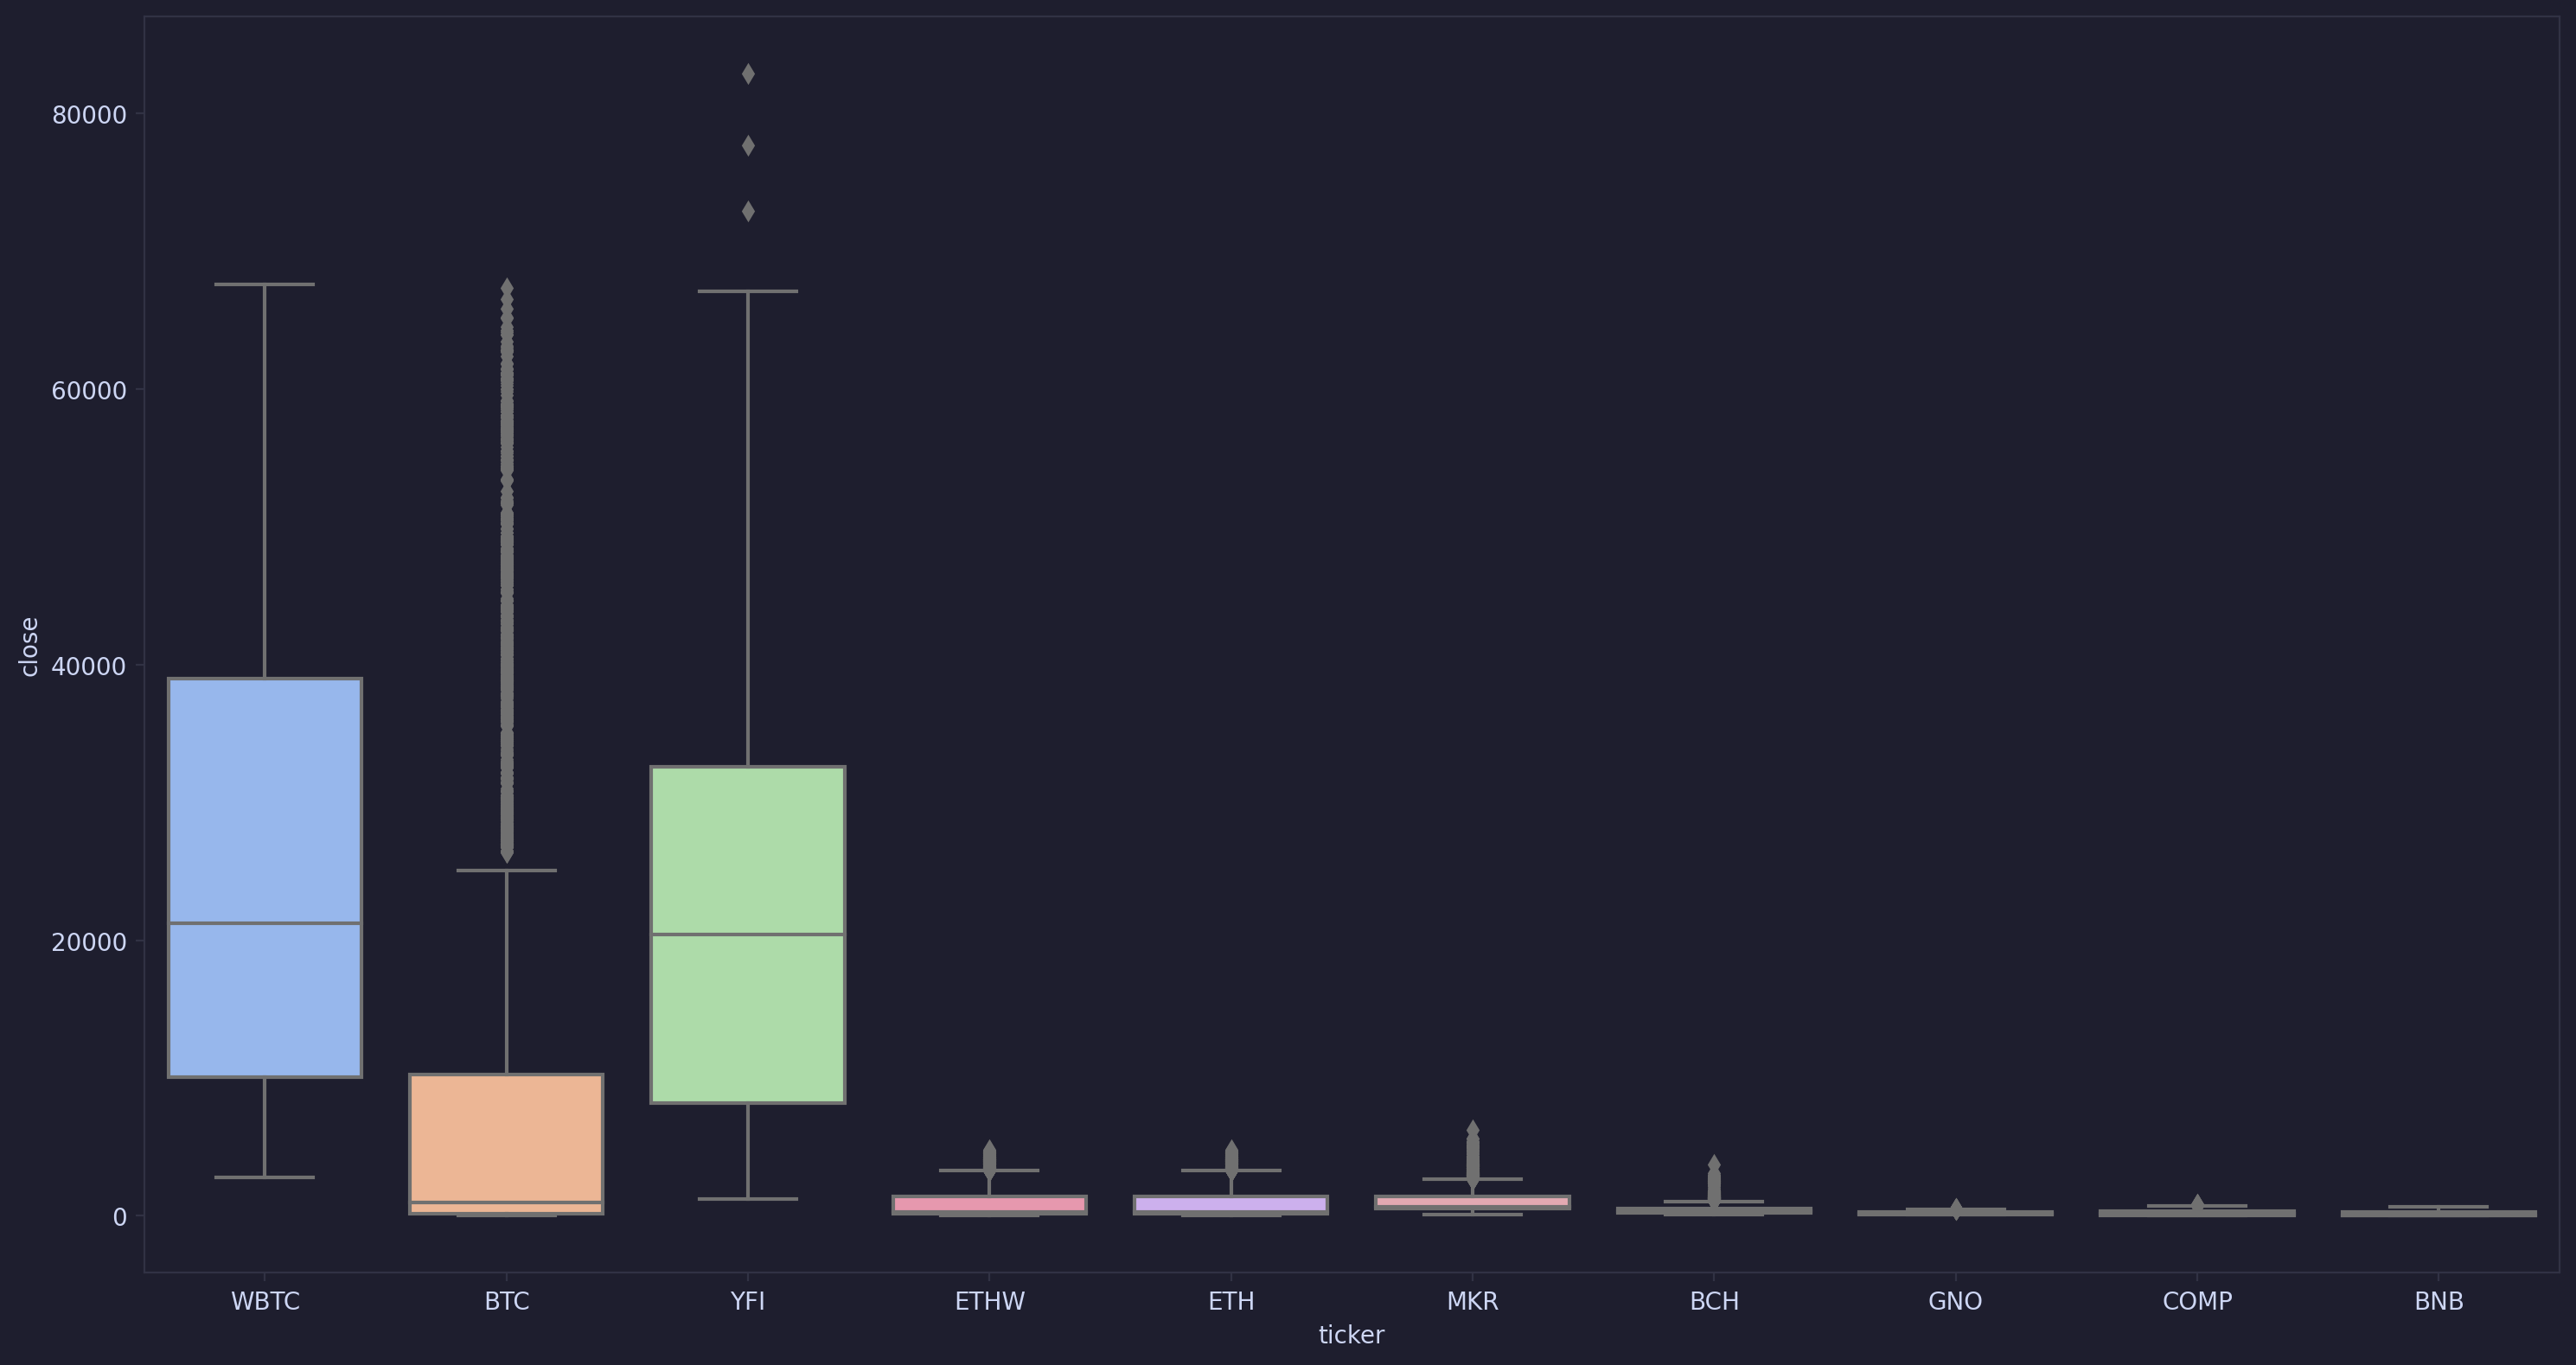

In [9]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_5, x='ticker', y='close')

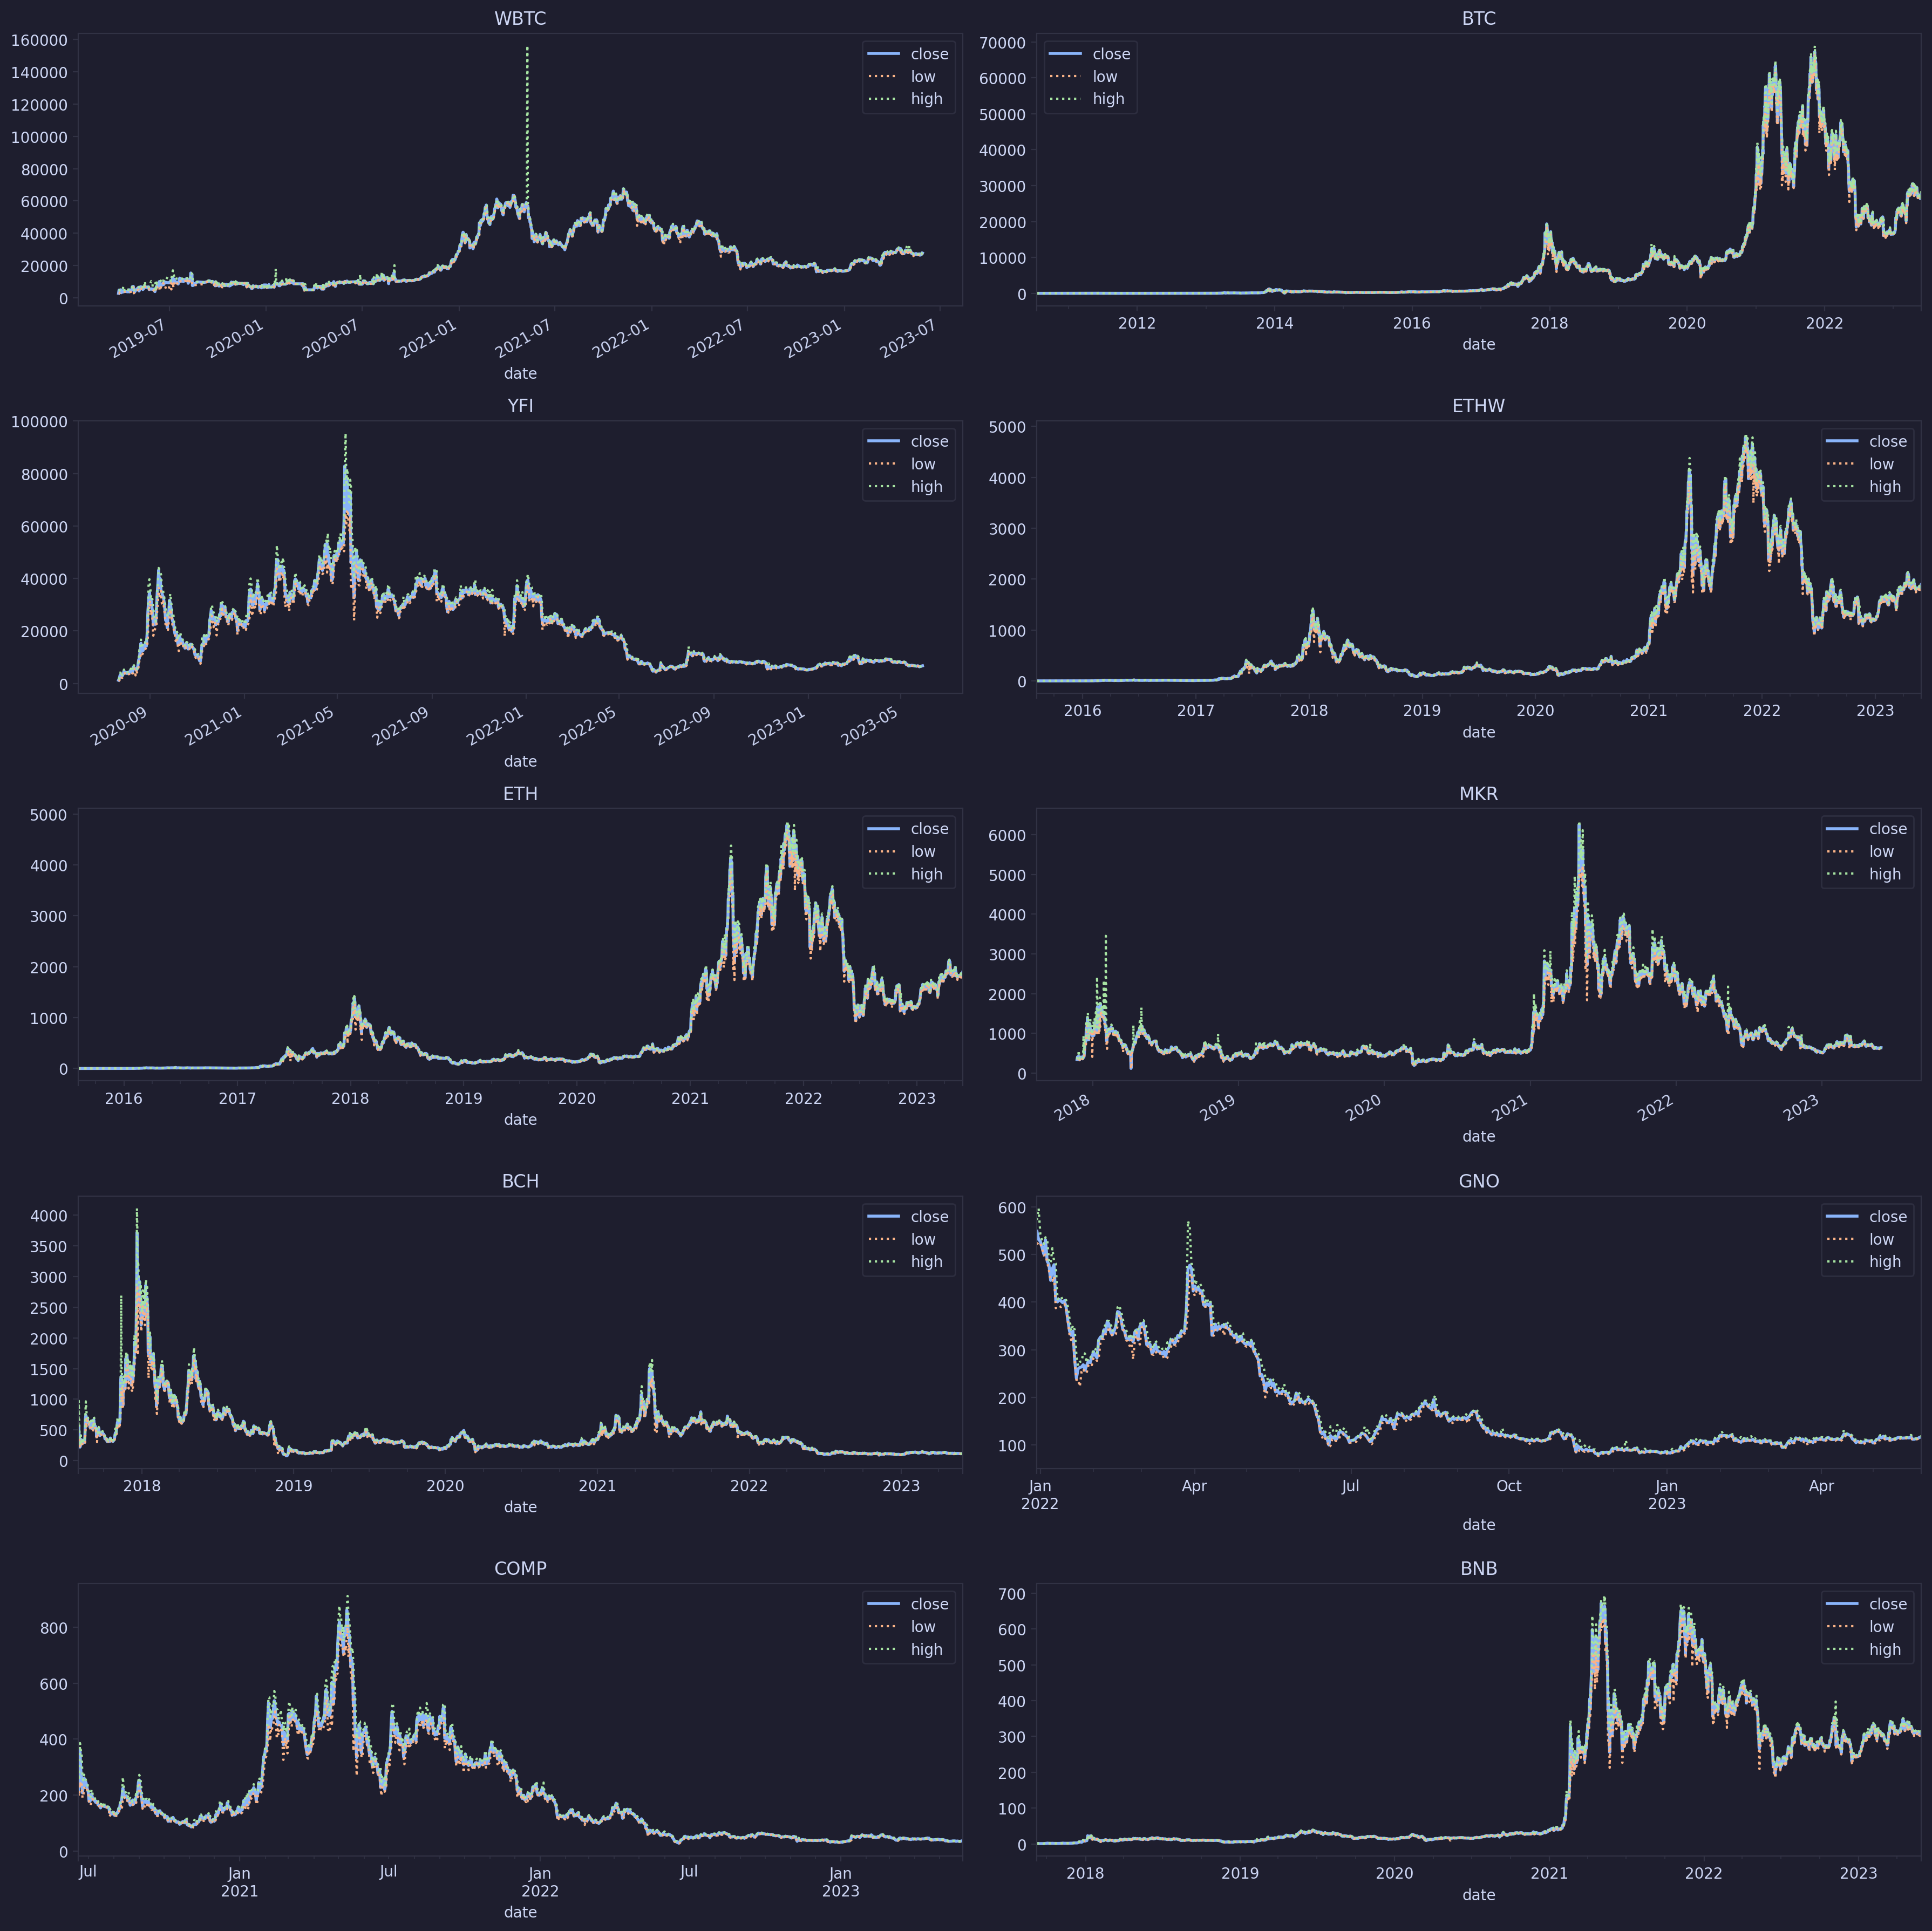

In [10]:
plt.figure(figsize=(18,18))
for j, i in enumerate(select):
    df_ = df_5.loc[df_5['ticker']==i]
    ax = plt.subplot(5,2,j+1)
    df_.plot(x='date', y='close', ax=ax, linewidth=2)
    df_.plot(x='date', y='low', ax=ax, style=':')
    df_.plot(x='date', y='high', ax=ax, style=':')
    plt.title(i)

In [11]:
btc = pd.read_csv('BTC.csv', parse_dates=['date'])
btc = btc.drop('ticker', axis=1)

btc.head()

,date,open,high,low,close
0,2010-07-17,0.04951,0.04951,0.04951,0.04951
1,2010-07-18,0.04951,0.08585,0.04951,0.08584
2,2010-07-19,0.08584,0.09307,0.07723,0.08080
3,2010-07-20,0.08080,0.08181,0.07426,0.07474
4,2010-07-21,0.07474,0.07921,0.06634,0.07921


<Axes: xlabel='date'>

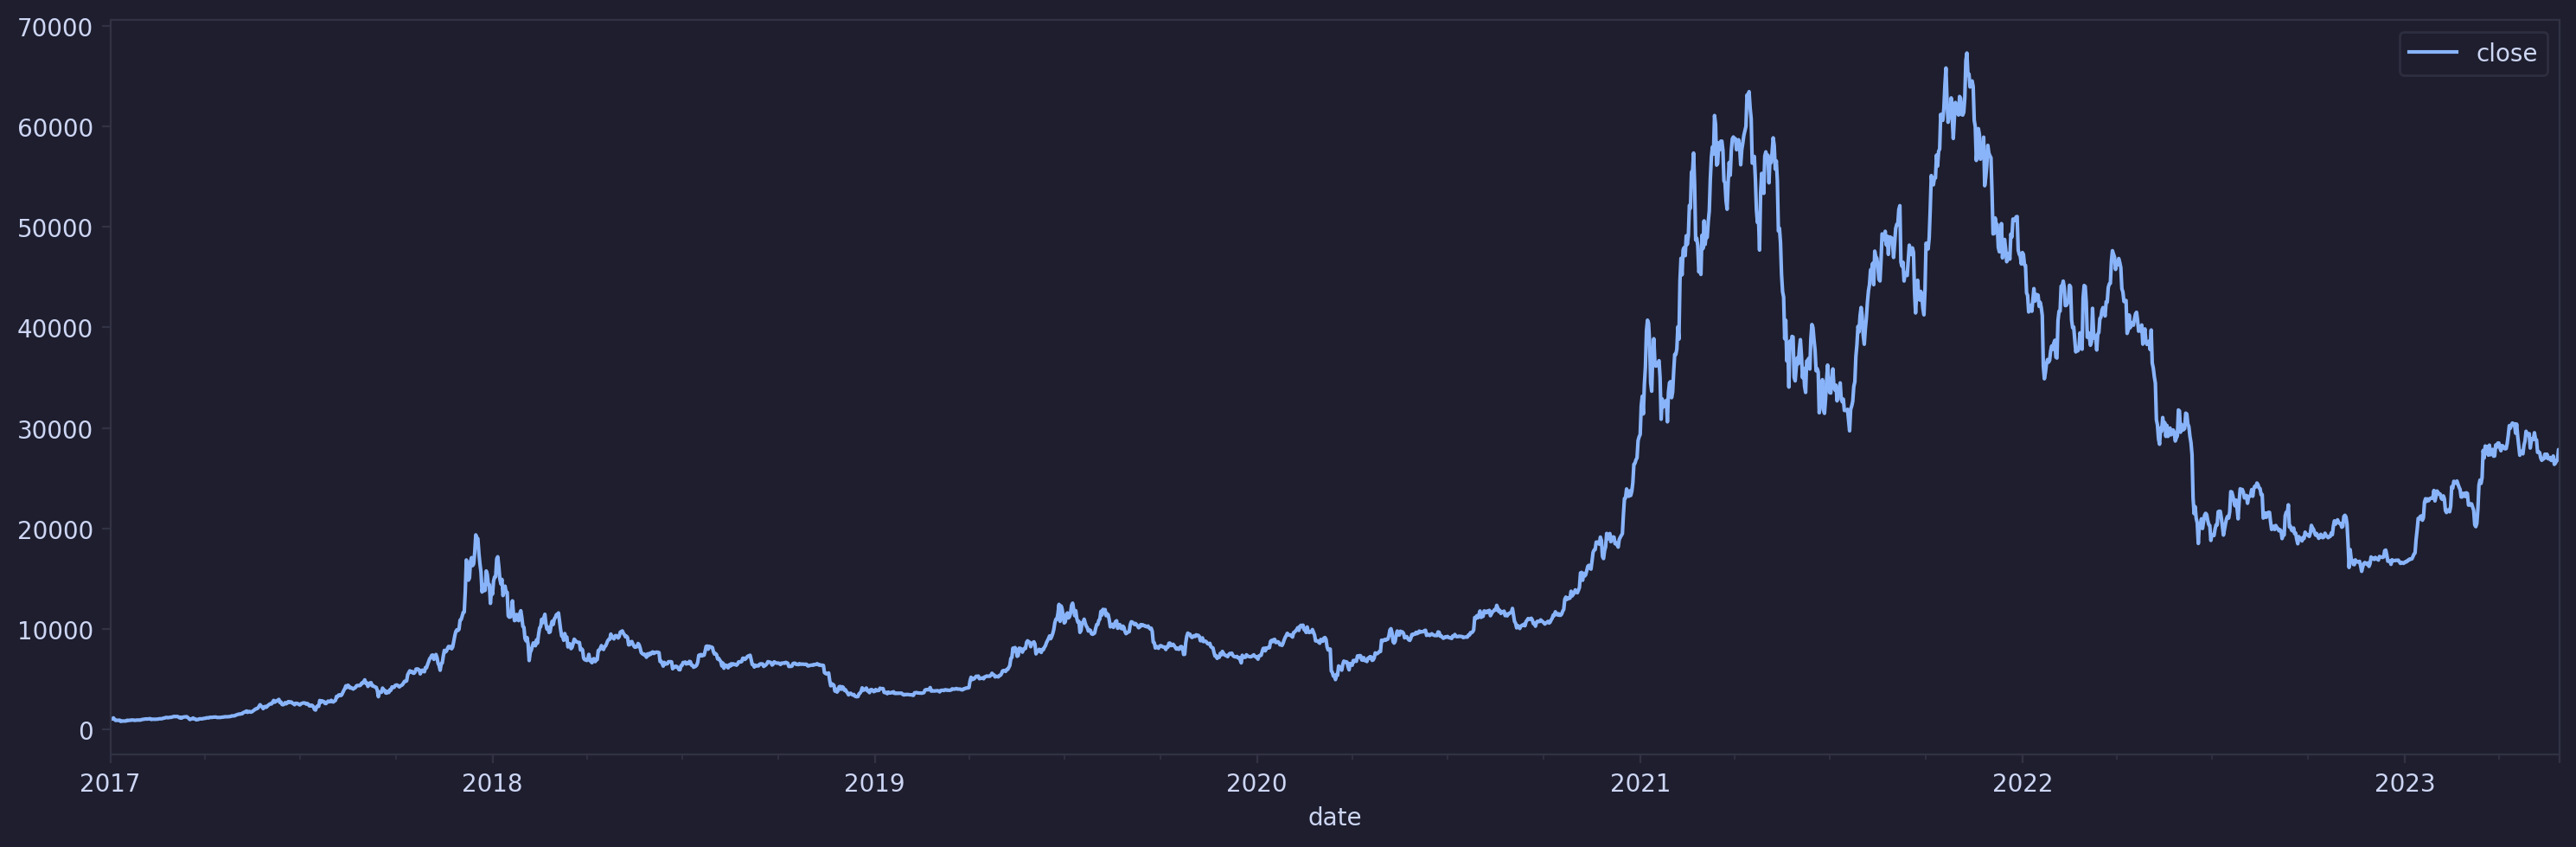

In [12]:
btc = btc[btc['date']>='2017-01-01']
btc.plot(y='close', x='date')

In [13]:
btc['week'] = btc['date'].dt.isocalendar().week.astype(np.int32)
btc['dayofweek'] = btc['date'].dt.dayofweek.astype(np.int32)
btc['year'] = btc['date'].dt.year.astype(np.int32)
# btc['dayofyear'] = btc['date'].dt.dayofyear.astype(np.int32)
btc.head()

,date,open,high,low,close,week,dayofweek,year
2360,2017-01-01,963.38,1001.61,956.10,995.44,52,6,2017
2361,2017-01-02,995.44,1031.68,990.20,1017.05,1,0,2017
2362,2017-01-03,1017.05,1035.47,1006.53,1033.30,1,1,2017
2363,2017-01-04,1033.30,1148.54,1022.32,1135.41,1,2,2017
2364,2017-01-05,1135.41,1150.63,874.53,989.35,1,3,2017


In [14]:
btc = btc.rename(columns={'date':'ds', 'close':'y'})
btc.shape

(2340, 8)

In [15]:
from prophet import Prophet
m = Prophet(seasonality_mode='additive')
m.add_regressor('dayofweek')
m.add_regressor('week')
m.add_regressor('year')
# m.add_regressor('dayofyear')
m.fit(btc)

future = m.make_future_dataframe(periods=90, freq='D')
future['dayofweek'] = future['ds'].dt.dayofweek.astype(np.int32)
future['week'] = future['ds'].dt.isocalendar().week.astype(np.int32)
future['year'] = future['ds'].dt.year.astype(np.int32)
# future['dayofyear'] = future['ds'].dt.dayofyear
preds = m.predict(future)

22:26:20 - cmdstanpy - INFO - Chain [1] start processing
22:26:20 - cmdstanpy - INFO - Chain [1] done processing


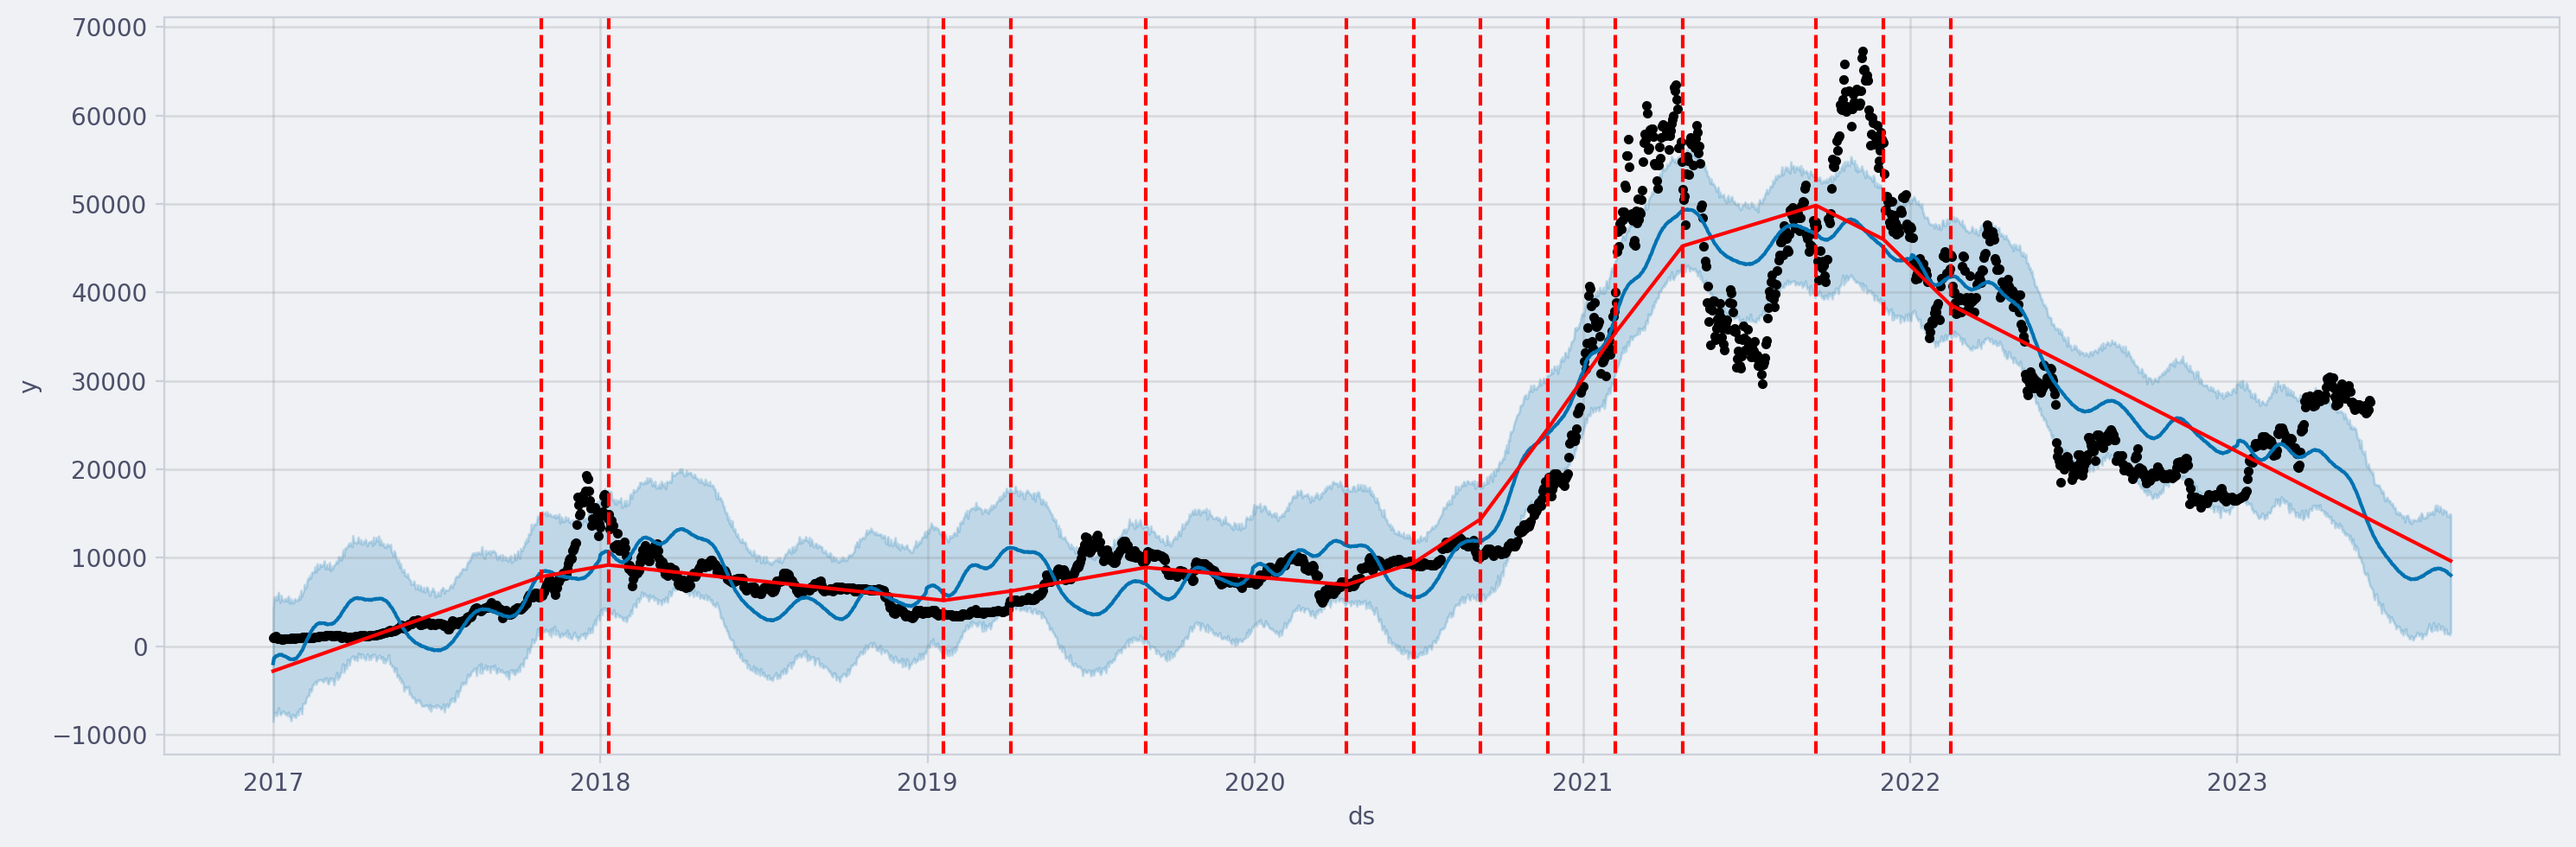

In [16]:
from prophet.plot import add_changepoints_to_plot

mpl.style.use('latte')
fig, ax = plt.subplots(figsize=(15,5))
fig = m.plot(preds, ax=ax)
a = add_changepoints_to_plot(plt.gca(), m, preds)

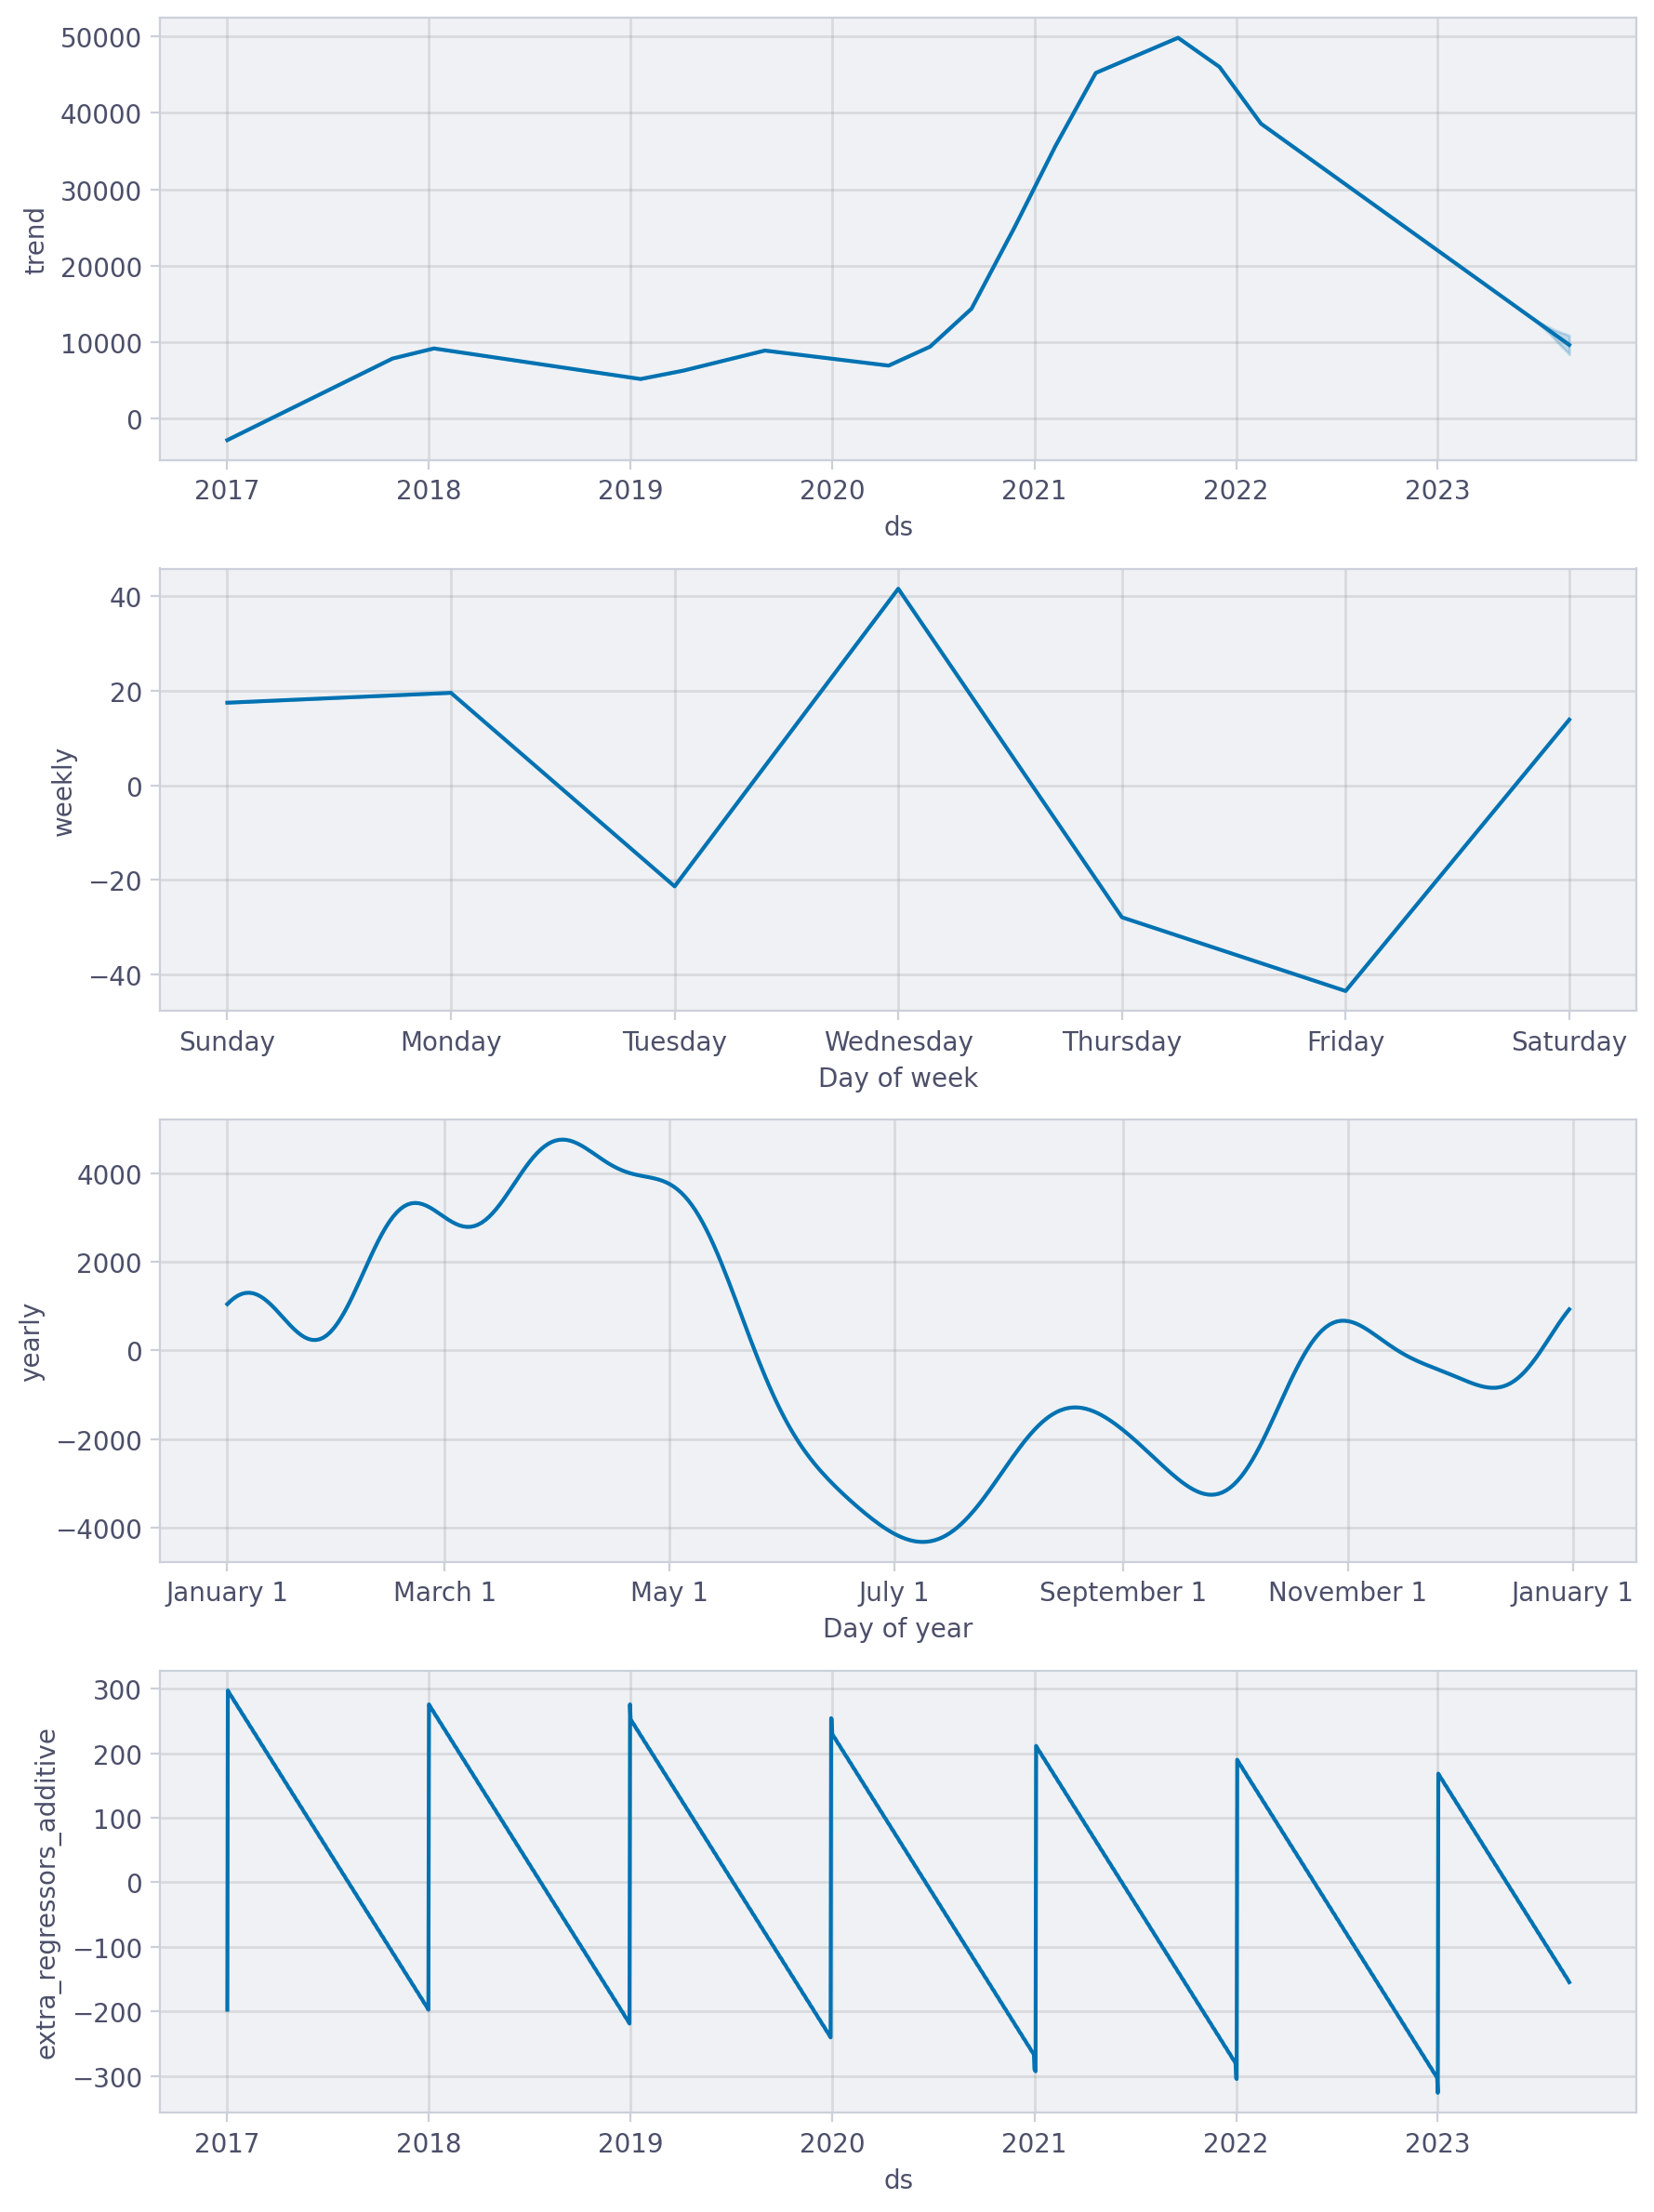

In [17]:
fig = m.plot_components(preds)

In [18]:
change_points = m.changepoints.to_list()
change_points.append('2023-01-05')
change_points.append('2023-04-18')

In [19]:
m = Prophet(seasonality_mode='additive', changepoints=change_points)
m.add_regressor('dayofweek')
m.add_regressor('week')
m.add_regressor('year')
# m.add_regressor('dayofyear')
m.fit(btc)

future = m.make_future_dataframe(periods=90, freq='D')
future['dayofweek'] = future['ds'].dt.dayofweek.astype(np.int32)
future['week'] = future['ds'].dt.isocalendar().week.astype(np.int32)
future['year'] = future['ds'].dt.year.astype(np.int32)
# future['dayofyear'] = future['ds'].dt.dayofyear
preds = m.predict(future)

22:26:22 - cmdstanpy - INFO - Chain [1] start processing
22:26:22 - cmdstanpy - INFO - Chain [1] done processing


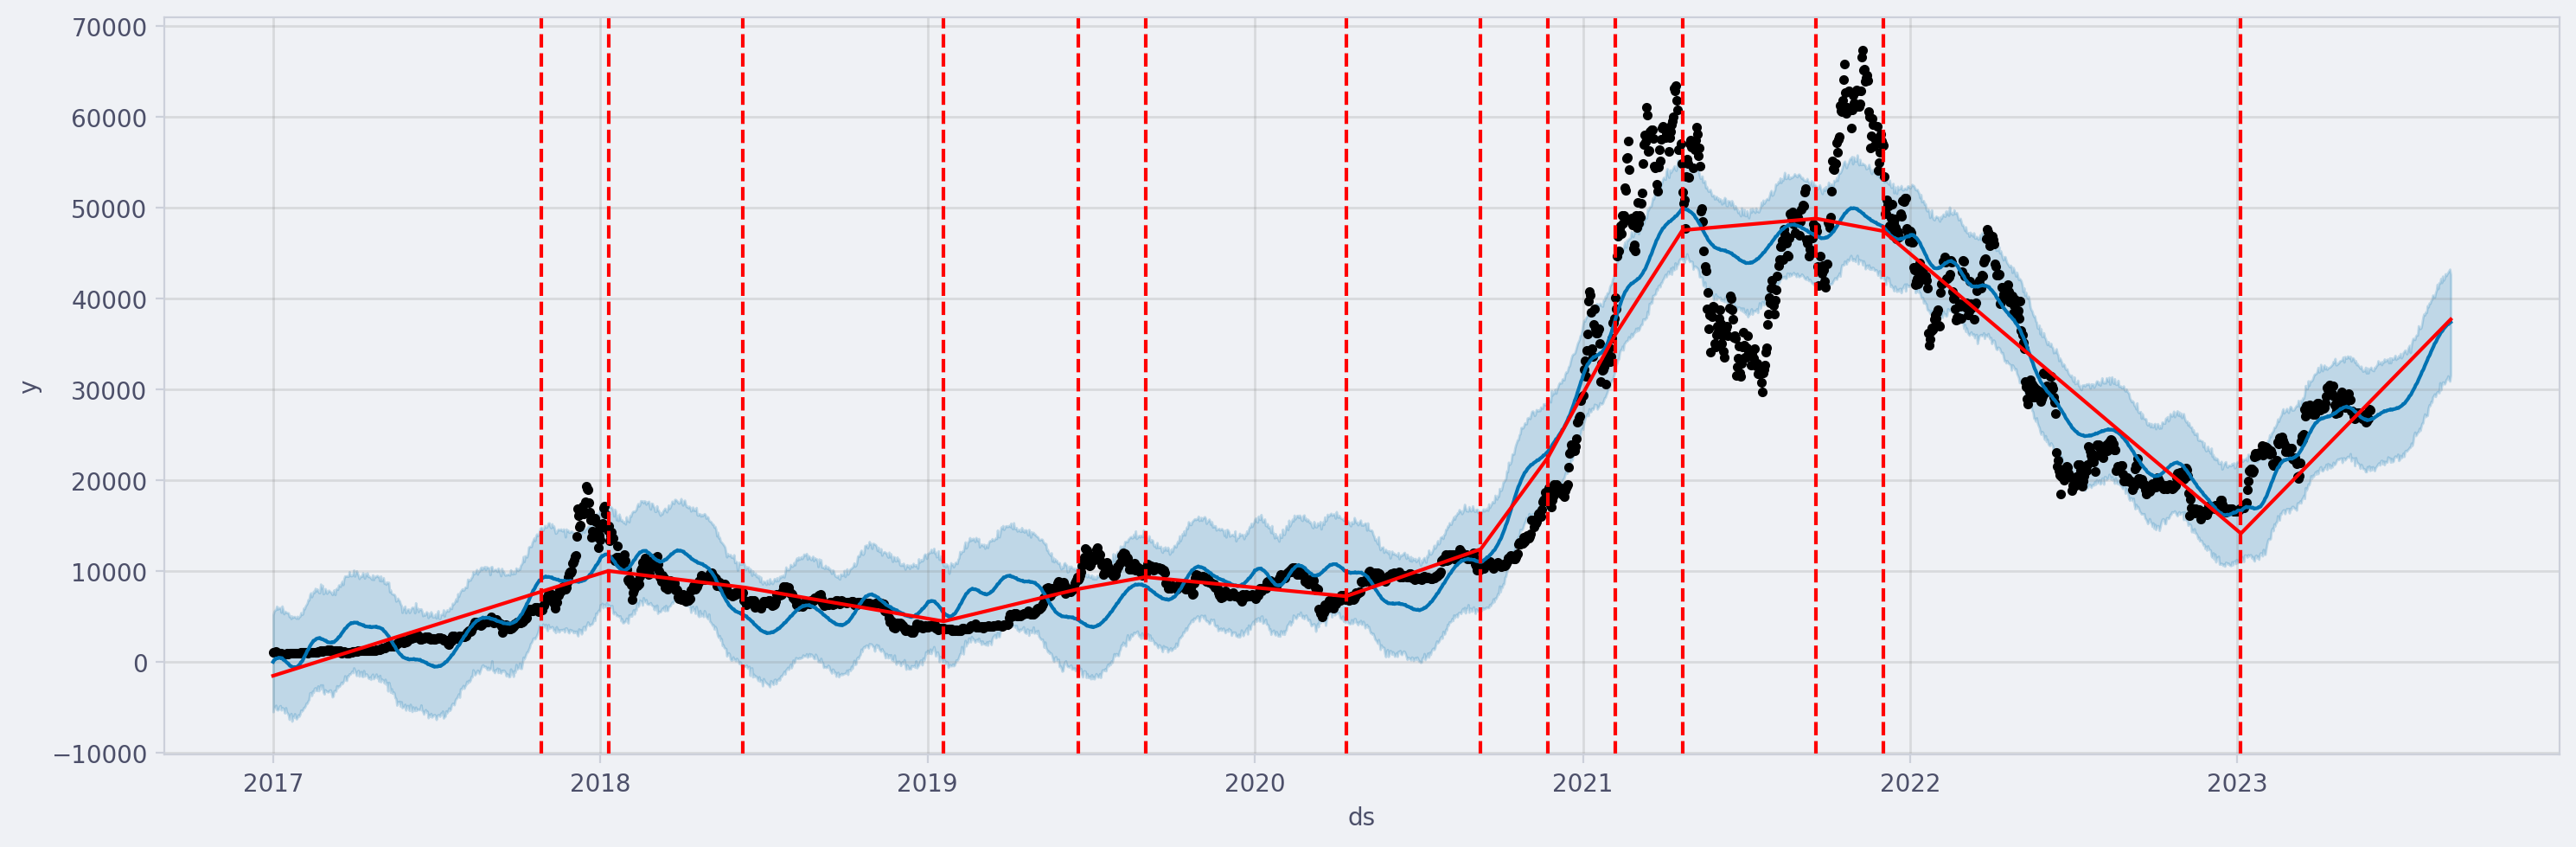

In [20]:
mpl.style.use('latte')
fig, ax = plt.subplots(figsize=(15,5))
fig = m.plot(preds, ax=ax)
a = add_changepoints_to_plot(plt.gca(), m, preds)

In [21]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model=m,
                         initial='366 days',
                         period='183 days',
                         horizon='91 days')

  0%|          | 0/11 [00:00<?, ?it/s]

22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:24 - cmdstanpy - INFO - Chain [1] done processing
22:26:24 - cmdstanpy - INFO - Chain [1] start processing
22:26:24 - cmdstanpy - INFO - Chain [1] done processing
22:26:24 - cmdstanpy - INFO - Chain [1] start process

<Axes: >

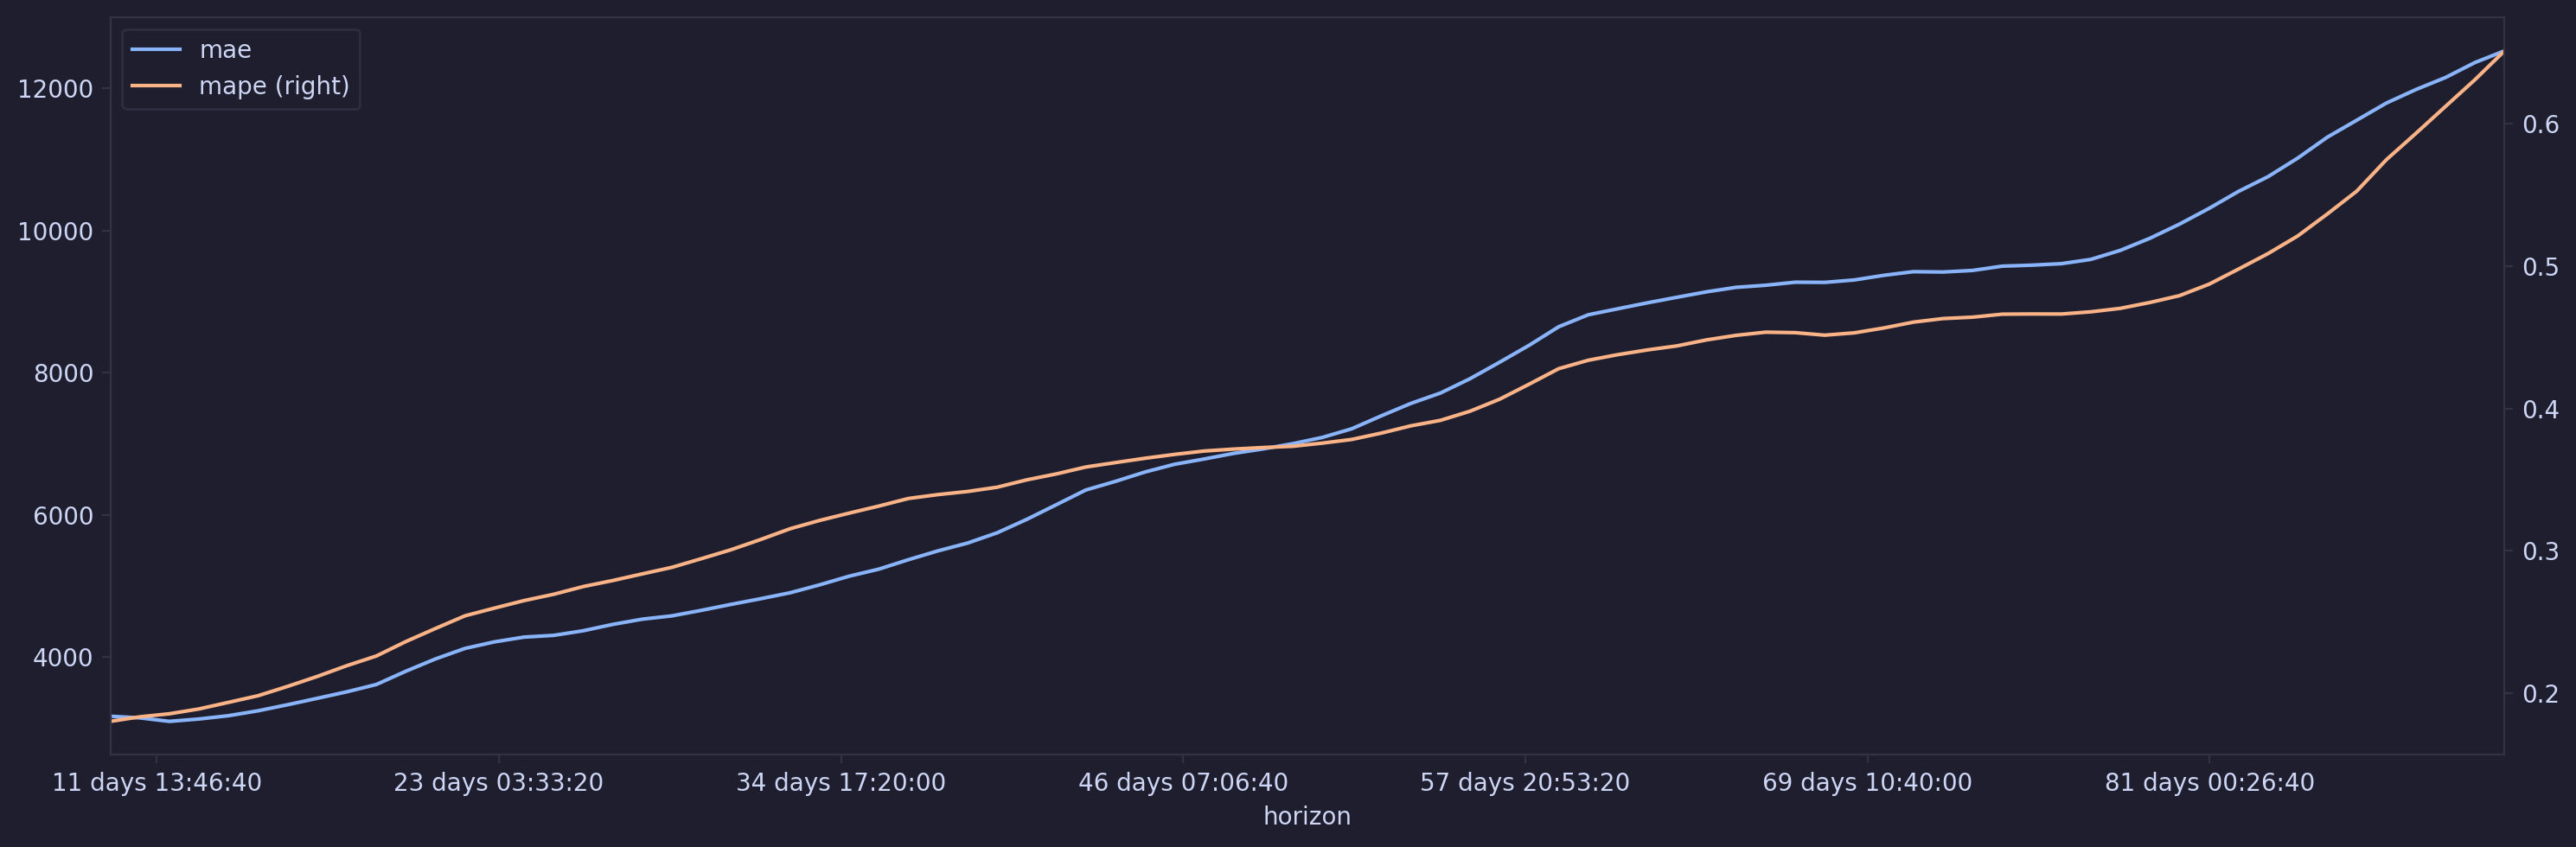

In [22]:
mpl.style.use('mocha')
metrics = performance_metrics(df_cv)
fig, ax = plt.subplots(figsize=(15,5))
metrics.plot(x='horizon', y='mae', ax=ax)
metrics.plot(x='horizon', y='mape',ax=ax, secondary_y=True)
# metrics.plot(x='horizon', y='mdape',ax=ax, secondary_y=True)

Text(11, 10000, 'Min MAPE: 18.03% | Min MAE: $3097.21')

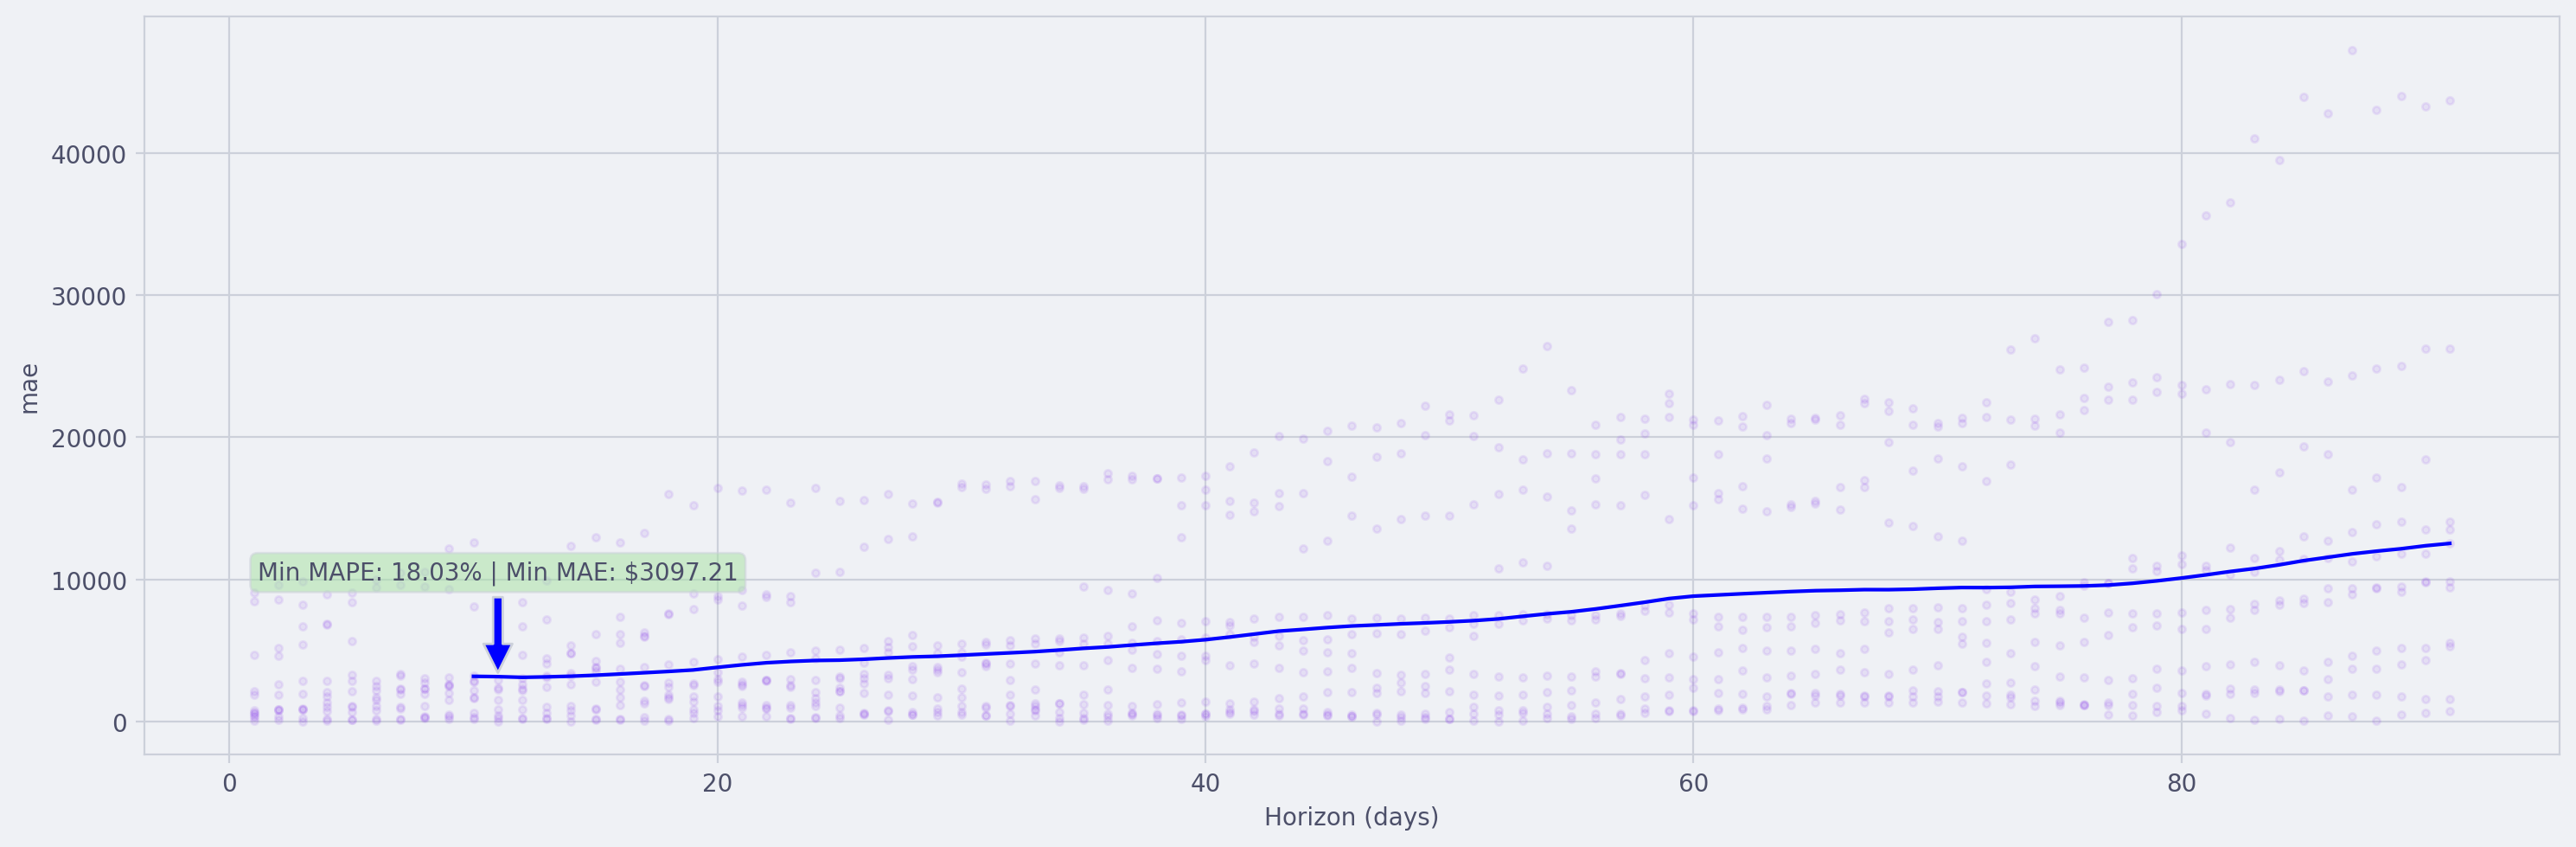

In [23]:
from prophet.plot import plot_cross_validation_metric
mpl.style.use('latte')
fig, ax = plt.subplots(figsize=(15,5))
fig = plot_cross_validation_metric(df_cv, metric='mae', point_color='#8839EF', ax=ax)
mape_min = metrics['mape'].min().squeeze()*100
mae_min = metrics['mae'].min().squeeze()
text = f'Min MAPE: {mape_min:.2f}% | Min MAE: ${mae_min:.2f}'
ax.annotate(text=text, xy=(11, metrics['mae'].min()), xytext=(11, 10000), arrowprops={'facecolor':'b', 'shrink':0.05}, ha='center', bbox={'boxstyle':'round', 'alpha':0.5, 'fc':'#A6E3A1'})